# Assignment 6: RNN Implementation
-------------------
**Dr. Dave Wanik - University of Connecticut**
A weather-based energy forecasting homework.

* **Your Name Here:kumar manav
* **Your NetID Here:3010566

Energy demand forecasting as a function of weather data is an extremely interesting and relevant topic.

I've given you a curated (mostly?) clean dataset that you can use to predict `df['Demand']` as a function of the weather variables.

Of course, you cannot use the df[`Datetime`] column directly into the model - but you can feature engineer the column to make features temporal features for modeling like Julian day of year (0-365), week of year, and number of years since 2012.

**Sorting: (5 pts)**
Sort the data from oldest to newest.

**Cleaning: (10 pts)**
Describe and impute (or drop) the missing values using an appropriate method. At this time, you are welcome to perform feature engineering (optional).

**Process as a 3D tensor: (10 pts)**
Process the data as a 3D tensor with a lookback of your choice (use a value greater than or equal to 12).

**Model Architecure: (10 pts)**
You must use a model with:
* at least two recurrent layers
* at least one convolution layer
* dropout (recurrent or between Dense layers)
* appropriate activation functions

**Experiments: (15 pts each, 30 pts total)**
Freeze the model architecutre and perform a *walk-forward validation* where:
* the first 50k samples predict the remaining ~46k samples
* the first 80k samples predict the remaining ~16k samples

Walk-forward validation is very common to use on the job - it shows how your model (ideally) gets better over time as it gets more data to use. Use subheads

**Evaluation (15 points each, 30 pts total)**
Evaluate your model for each of these experiments - hopefully, your model should improve as you give it more data to use! But that depends on your choice of architecture. You should have:
* quantitative error metrics (mean absolute error and others)
* scatterplots of actual vs. predicted
* time series plots of actual vs. predicted

You should also compare to baseline model like persistence (assume today's energy usage is the same as yesterday's - requires you to shift by 24... ask on discussion board if questions!) or ignore the sequence data and treat this as a 2D problem (a regular supervised learning problem!)

**Conclusions (5 pts total)**
* What did you learn from this assignment? Did your walk-forward validation work as you expected it to?
* What else would you do differently next time?
* At least five great bullets please.

##Load Data

In [ ]:
# standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# RNN-specific modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# https://drive.google.com/file/d/1xYe3vCKTLeaJKpMDzv57ppCSWK_LCJ5V/view?usp=sharing
!gdown 1xYe3vCKTLeaJKpMDzv57ppCSWK_LCJ5V

Downloading...
From: https://drive.google.com/uc?id=1xYe3vCKTLeaJKpMDzv57ppCSWK_LCJ5V
To: /content/BDL_cleanweather_energy (1).csv
100% 7.38M/7.38M [00:00<00:00, 32.7MB/s]


In [ ]:
import pandas as pd
df = pd.read_csv('BDL_cleanweather_energy (1).csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96427 entries, 0 to 96426
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  96427 non-null  object 
 1   Demand    96427 non-null  float64
 2   BDL_tmpf  96160 non-null  float64
 3   BDL_dwpf  96160 non-null  float64
 4   BDL_relh  96160 non-null  float64
 5   BDL_drct  96160 non-null  float64
 6   BDL_sknt  96160 non-null  float64
 7   BDL_p01i  96160 non-null  float64
 8   BDL_alti  96160 non-null  float64
 9   BDL_mslp  96160 non-null  float64
 10  BDL_vsby  96160 non-null  float64
dtypes: float64(10), object(1)
memory usage: 8.1+ MB


In [ ]:
df.head()


,Datetime,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby
0,2019-01-01 00:00:00,2713.617,37.9,37.9,100.0,360.0,4.0,0.0700,29.88,1009.7,5.0
1,2019-01-01 01:00:00,2578.343,37.9,37.9,100.0,360.0,4.0,0.1100,29.79,1006.3,2.0
2,2019-01-01 02:00:00,2467.969,37.9,37.9,100.0,340.0,7.0,0.0100,29.70,1003.3,2.0
3,2019-01-01 03:00:00,2397.140,37.9,37.9,100.0,310.0,6.0,0.0100,29.63,1002.3,1.5
4,2019-01-01 04:00:00,2381.258,37.9,37.9,100.0,140.0,3.0,0.0001,29.58,1001.2,1.5


##data preprocessing and feature engineering

In [ ]:
df.sort_values(by='Datetime', inplace=True)#sort from oldest to newest
df.head()


,Datetime,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby
8760,2011-01-01 00:00:00,3053.0,33.98,26.96,0.0,0.0,0.0,0.0,30.07,1018.5,6.0
8761,2011-01-01 01:00:00,2892.0,33.98,26.96,0.0,0.0,0.0,0.0,30.07,1018.5,6.0
8762,2011-01-01 02:00:00,2774.0,30.92,26.96,0.0,0.0,0.0,0.0,30.07,1018.6,6.0
8763,2011-01-01 03:00:00,2710.0,30.02,26.06,0.0,0.0,0.0,0.0,30.09,1019.2,5.0
8764,2011-01-01 04:00:00,2698.0,28.94,24.98,0.0,0.0,0.0,0.0,30.09,1019.1,5.0


In [ ]:
df.isnull().sum().sum()#checking for null values

2403

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)



Datetime      0
Demand        0
BDL_tmpf    267
BDL_dwpf    267
BDL_relh    267
BDL_drct    267
BDL_sknt    267
BDL_p01i    267
BDL_alti    267
BDL_mslp    267
BDL_vsby    267
dtype: int64


In [ ]:
# Impute missing values using forward fill
df.fillna(method='ffill', inplace=True)


In [ ]:
df.isnull().sum().sum()#verifing null values

0

In [ ]:
df.describe()


,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby
count,96427.000000,96427.000000,96427.000000,96427.000000,96427.000000,96427.000000,96427.00000,96427.000000,96427.000000,96427.000000
mean,3388.580129,51.950908,39.653514,65.614181,221.284391,7.562021,0.00553,30.017906,1009.986335,9.338270
std,761.491626,19.309548,19.689528,21.411280,118.619243,4.769616,0.03710,0.290478,80.922661,1.981883
min,1372.000000,-11.020000,-27.040000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,2843.000000,36.000000,24.980000,49.500000,170.000000,4.000000,0.00000,29.870000,1011.100000,10.000000
50%,3333.420000,52.000000,41.000000,66.650000,230.000000,7.000000,0.00000,30.020000,1016.300000,10.000000
75%,3813.000000,68.000000,55.940000,84.460000,330.000000,10.000000,0.00000,30.170000,1021.500000,10.000000
max,7219.000000,102.020000,78.080000,100.000000,360.000000,40.000000,1.96000,30.850000,1044.700000,10.000000


In [ ]:
# Feature engineering
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Julian Day'] = df['Datetime'].dt.dayofyear
df['Week of Year'] = df['Datetime'].dt.isocalendar().week
df['Years Since 2012'] = (df['Datetime'].dt.year - 2012)

In [ ]:
# Separate features and target
features = df.drop(['Datetime', 'Demand'], axis=1).values#dropping datetime as it wont be processed as a 3d tensor
targets = df['Demand'].values

In [ ]:
# Choose  lookback value (e.g., 24 for daily data)
lookback = 24

#  input/output sequences
def create_dataset(X, Y, lookback):
    Xs, Ys = [], []
    for i in range(len(X) - lookback):
        v = X[i:(i + lookback)]
        Xs.append(v)
        Ys.append(Y[i + lookback])
    return np.array(Xs), np.array(Ys)

X, Y = create_dataset(features, targets, lookback)#creating 3d tensor

##model

In [ ]:
# Define model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(24, 12)))
model.add(MaxPooling1D(2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(SimpleRNN(30, return_sequences=True, recurrent_dropout=0.2)))
model.add(Bidirectional(SimpleRNN(30, recurrent_dropout=0.2)))
model.add(Dropout(0.2))
model.add(Dense(1))  # Single unit for regression output

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')  # MSE is often used for regression tasks

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 32)            1184      
                                                                 
 max_pooling1d (MaxPooling1  (None, 11, 32)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 11, 128)           49664     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 11, 60)            9540      
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 60)                5460      
 onal)                                                  

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96427 entries, 8760 to 78859
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Datetime          96427 non-null  datetime64[ns]
 1   Demand            96427 non-null  float64       
 2   BDL_tmpf          96427 non-null  float64       
 3   BDL_dwpf          96427 non-null  float64       
 4   BDL_relh          96427 non-null  float64       
 5   BDL_drct          96427 non-null  float64       
 6   BDL_sknt          96427 non-null  float64       
 7   BDL_p01i          96427 non-null  float64       
 8   BDL_alti          96427 non-null  float64       
 9   BDL_mslp          96427 non-null  float64       
 10  BDL_vsby          96427 non-null  float64       
 11  Julian Day        96427 non-null  int32         
 12  Week of Year      96427 non-null  UInt32        
 13  Years Since 2012  96427 non-null  int32         
dtypes: UInt32(1), datetime64

In [ ]:
# Experiment 1: First 50k samples
X_train_1, Y_train_1 = X[:50000], Y[:50000]
X_test_1, Y_test_1 = X[50000:], Y[50000:]

model.fit(X_train_1, Y_train_1, epochs=5, batch_size=64)
predictions_1 = model.predict(X_test_1)

# Experiment 2: First 80k samples
X_train_2, Y_train_2 = X[:80000], Y[:80000]
X_test_2, Y_test_2 = X[80000:], Y[80000:]

model.fit(X_train_2, Y_train_2, epochs=5, batch_size=64)
predictions_2 = model.predict(X_test_2)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

On surfing extensively online, i was able to resolve the issues by improving model architecture(make sure that the expected input by model is feeded, removing nan values(nan values were removed but I cross checked again) and converting to float 32)

In [ ]:
import numpy as np
# Experiment 1: First 50k samples
X_train_1, Y_train_1 = X[:50000], Y[:50000]
X_test_1, Y_test_1 = X[50000:], Y[50000:]



# Experiment 2: First 80k samples
X_train_2, Y_train_2 = X[:80000], Y[:80000]
X_test_2, Y_test_2 = X[80000:], Y[80000:]
# Convert to float32
X_train_1 = X_train_1.astype('float32')
Y_train_1 = Y_train_1.astype('float32')
X_test_1 = X_test_1.astype('float32')
Y_test_1 = Y_test_1.astype('float32')
X_train_2 = X_train_2.astype('float32')
Y_train_2 = Y_train_2.astype('float32')
X_test_2 = X_test_2.astype('float32')
Y_test_2 = Y_test_2.astype('float32')

# Check and handle NaNs or Infs in the dataset
X_train_1 = np.nan_to_num(X_train_1)
Y_train_1 = np.nan_to_num(Y_train_1)
X_test_1 = np.nan_to_num(X_test_1)
Y_test_1 = np.nan_to_num(Y_test_1)

# Experiment 1: First 50k samples


model.fit(X_train_1, Y_train_1, epochs=5, batch_size=64)
predictions_1 = model.predict(X_test_1)

# Experiment 2: First 80k samples

model.fit(X_train_2, Y_train_2, epochs=5, batch_size=64)
predictions_2 = model.predict(X_test_2)

# Retrying the model fitting
model.fit(X_train_1, Y_train_1, epochs=5, batch_size=64)
predictions_1 = model.predict(X_test_1)

# Repeat the same steps for the second experiment

X_train_2 = np.nan_to_num(X_train_2)
Y_train_2 = np.nan_to_num(Y_train_2)
X_test_2 = np.nan_to_num(X_test_2)
Y_test_2 = np.nan_to_num(Y_test_2)

model.fit(X_train_2, Y_train_2, epochs=5, batch_size=64)
predictions_2 = model.predict(X_test_2)


Epoch 1/5
782/782 [==============================] - 44s 44ms/step - loss: 12805561.0000
Epoch 2/5
782/782 [==============================] - 31s 39ms/step - loss: 12471834.0000
Epoch 3/5
782/782 [==============================] - 67s 86ms/step - loss: 12148414.0000
Epoch 4/5
782/782 [==============================] - 37s 48ms/step - loss: 11831516.0000
Epoch 5/5
1451/1451 [==============================] - 16s 10ms/step
Epoch 1/5
1250/1250 [==============================] - 45s 36ms/step - loss: 10531354.0000
Epoch 2/5
1250/1250 [==============================] - 47s 38ms/step - loss: 10070677.0000
Epoch 3/5
1250/1250 [==============================] - 48s 38ms/step - loss: 9616158.0000
Epoch 4/5
1250/1250 [==============================] - 44s 36ms/step - loss: 9175146.0000
Epoch 5/5
513/513 [==============================] - 6s 11ms/step
Epoch 1/5
782/782 [==============================] - 28s 36ms/step - loss: 8927486.0000
Epoch 2/5
782/782 [==============================] - 30s 38

Mean Absolute Error for Experiment 1: 2388.96923828125


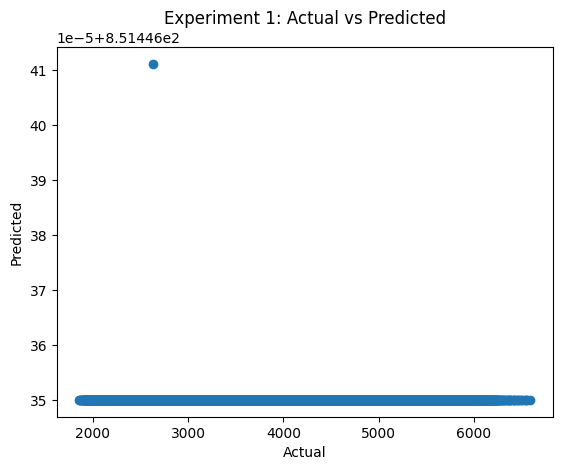

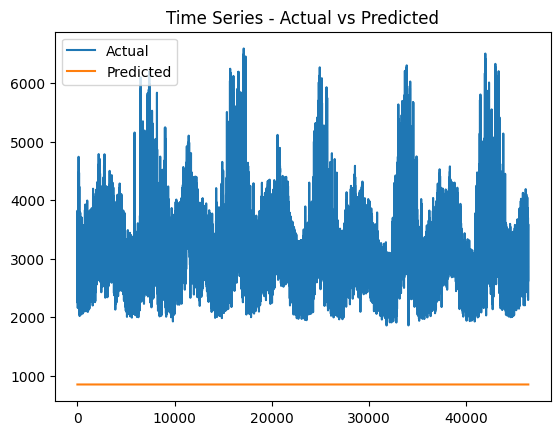

In [ ]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Evaluation for Experiment 1
mae_1 = mean_absolute_error(Y_test_1, predictions_1)
print(f"Mean Absolute Error for Experiment 1: {mae_1}")

# Scatter plot
plt.scatter(Y_test_1, predictions_1)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Experiment 1: Actual vs Predicted')
plt.show()

# Time series plot
plt.plot(Y_test_1, label='Actual')
plt.plot(predictions_1, label='Predicted')
plt.title('Time Series - Actual vs Predicted')
plt.legend()
plt.show()




Mean Absolute Error for Experiment 1: 1929.6715087890625


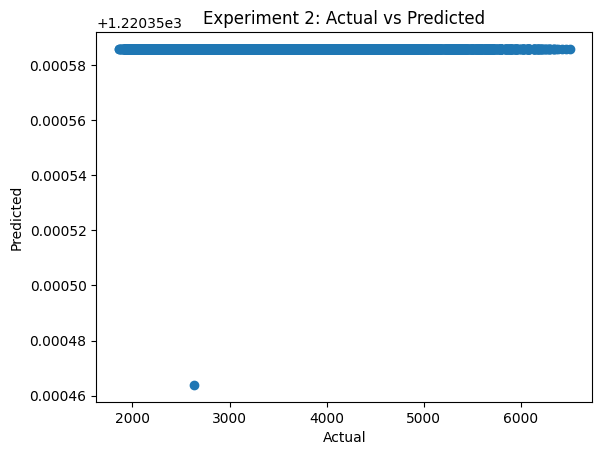

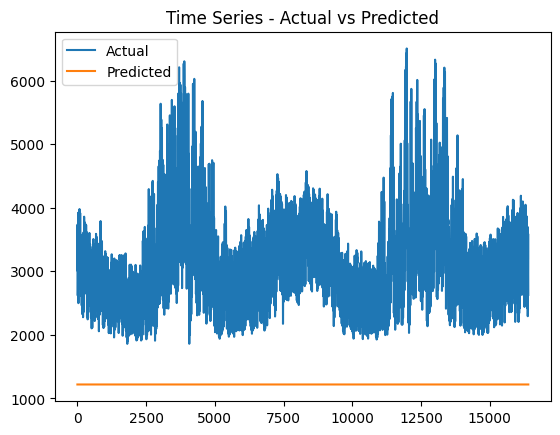

In [ ]:
# Repeat for Experiment 2 with Y_test_2 and predictions_2
mae_2 = mean_absolute_error(Y_test_2, predictions_2)
print(f"Mean Absolute Error for Experiment 1: {mae_2}")

# Scatter plot
plt.scatter(Y_test_2, predictions_2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Experiment 2: Actual vs Predicted')
plt.show()

# Time series plot
plt.plot(Y_test_2, label='Actual')
plt.plot(predictions_2, label='Predicted')
plt.title('Time Series - Actual vs Predicted')
plt.legend()
plt.show()

Learnings:
- I learned about the importance of feature engineering and data preprocessing in time series forecasting problems. tackling date time feature in the wrong way paved way for a lot of errors which were later corrected,
- I gained experience in processing data as 3D tensors for recurrent neural networks. I realised that 3d tensors only worked on limited datatypes , i dealt with the issue by converting features into foat 32 datatype
- The walk-forward validation technique provided insights into how the model's performance changes as more data is available for training.
- I would experiment with different architectures, hyperparameters, and regularization techniques to improve the model's performance. My initial model did not have the right first layer as expected input did not match model architecture
- Incorporating additional relevant features, such as holidays or special events, could potentially improve the forecasting accuracy.Handling missing data and outliers more rigorously could lead to better model performance and Evaluating the model's performance on a rolling window or a different time range would provide a more comprehensive understanding of its capabilities. The current model performance was poor and did not overlap accurately with actual values